In [181]:
import os
import copy
import time
import random
import pickle

import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm import tqdm

from sklearn.metrics import f1_score, confusion_matrix
from numpy.random import shuffle
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import torch.autograd.profiler as tprofiler
import torch.utils.data as td

plt.rcParams["savefig.bbox"] = 'tight'

In [182]:
seed = 42

random.seed(seed)

# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
np.random.seed(seed)

In [183]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [184]:
# from utils file

from torchvision import models
import torch.nn as nn

def set_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


def initialize_model(model_name, num_classes, feature_extract, use_pretrained=None):
    '''
    Initialize models for training.
    '''
    model_ft = None
    input_size = 0

    if model_name == "resnet50":
        """ 
            Returns a Resnet 50 model.
        """
        model_ft = models.resnet50(weights=use_pretrained)
        set_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 232
        
    elif model_name == "resnet34":
        """ 
            Returns a Resnet 34 model.
        """
        model_ft = models.resnet34(weights=use_pretrained)
        set_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 256

    elif model_name == "inceptionv3":
        """ 
            Returns an Inception v3 model.
        """
        model_ft = models.inception_v3(weights=use_pretrained)
        set_requires_grad(model_ft, feature_extract)
        # Auxilary network.
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Primary network.
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 299
        
    elif model_name == "vgg16":
        """ 
            Returns a VGG 16 model with batch normalization.
        """
        model_ft = models.vgg16_bn(weights=use_pretrained)
        set_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 256

    elif model_name == "mobile_net_v3_large":
        """ 
            returns a mobile net V3 large model.
        """
        model_ft = models.mobilenet_v3_large(weights=use_pretrained)
        set_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[3].in_features
        model_ft.classifier[3] = nn.Linear(num_ftrs, num_classes, bias=True)
        input_size = 232

    elif model_name == "efficient_net_b1":
        """ 
            Returns an efficient net b1 model.
        """
        model_ft = models.efficientnet_b1(weights=use_pretrained)
        set_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes, bias=True)
        input_size = 255

    elif model_name == "efficient_net_b0":
        """ 
            Returns an efficient net b0 model.
        """
        model_ft = models.efficientnet_b0(weights=use_pretrained)
        set_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes, bias=True)
        input_size = 256

    else:
        print("Unavailable model selected.")

    return model_ft, input_size

In [185]:
# Models options: resnet50, resnet34, inceptionv3, vgg16, mobile_net_v3_large, efficient_net_b1, efficient_net_b0.
model_name = "resnet34"

# Number of classes.
num_classes = 3

# Batch Size.
batch_size = 64

# Epochs to train for.
num_epochs = 100

# Number of workers for data loader.
num_workers = 12

# Imagenet norm array passed as default value.
norm_arr=([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# Chest x-ray8 training dataset metrics 
norm_arr=([0.4951, 0.4951, 0.4951], [0.2896, 0.2896, 0.2896])
# Covid Pneumonia dataset metrics
norm_arr = ([0.5159, 0.5159, 0.5159], [0.2554, 0.2554, 0.2554])

# Feature extract flag: False - Tune the whole model,
#                       True - Update only the reshaped layer parameters.
feature_extract = False

# Use pretrained flag: None - Use random weights
#                      String - Use pretrained weights given by String
use_pretrained = None

# Initialize the model for this run.
model_pyt, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=use_pretrained)

# lr start and end points for training.
lr_start = 0.01
lr_end = 0.001

# How many epochs to restart.
iter_restart = 10

# Multiplication factor after restart.
mul_restart = 1

# Print the model we just instantiated
#print(model_ft)

In [186]:
#dataloader function 
###########################
import os
import torchvision.transforms as T
from torchvision import datasets
import torch.utils.data as td

class_names = []

def load_data(path, batch_size, input_size, norm_arr, 
              num_workers=0):
    
    transform_dict = {"train": 
                          T.Compose([
                            #T.ToPILImage(),
                            T.Resize(size=input_size),

                            T.RandomHorizontalFlip(),
                            #T.ColorJitter(contrast=0.5),
                            T.RandomAdjustSharpness(2),
                            T.RandomAutocontrast(),

                            T.ToTensor(),
                            T.Normalize(*norm_arr)]),
                        "test_val": 
                          T.Compose([
                            #T.ToPILImage(),
                            T.Resize(size=input_size),
                            T.ToTensor(),
                            T.Normalize(*norm_arr)])
                        }
    
    
    #class_names = train_dataset.classes
    #print(class_names)

    test_dataset = datasets.ImageFolder(root=os.path.join(path, "test"),
                                        transform=transform_dict["test_val"])
    
    data_loader_test = td.DataLoader(test_dataset,
                                     batch_size=batch_size,
                                     shuffle=False,
                                     drop_last=False,
                                     num_workers=num_workers,
                                     pin_memory=True)

    return {'test':  data_loader_test}

In [187]:
images_dir = "drive/MyDrive/covid_pneumonia_test"

In [188]:
data_loaders = load_data(images_dir,
                         batch_size = batch_size, 
                         input_size = input_size, 
                         norm_arr = norm_arr,
                         num_workers = num_workers)

In [189]:
class_names = ['COVID', 'Normal', 'Viral Pneumonia']

In [190]:
#checked model layers

# Check if GPU is available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send model to GPU
model_pyt = model_pyt.to(device)


In [191]:
# load saved model directly
model_pyt.load_state_dict(torch.load('drive/MyDrive/resnet34_covid_pneumonia_100_32_0.01_0.001_model_weights.pth', map_location=device)) 

<All keys matched successfully>

# MobileNet

In [192]:
##Second model
model_name = "mobile_net_v3_large"

# Initialize the model for this run.
model_pyt2, input_size2 = initialize_model(model_name, num_classes, feature_extract, use_pretrained=use_pretrained)


In [193]:

# Send model to GPU
model_pyt2 = model_pyt2.to(device)



In [194]:
model_pyt2.load_state_dict(torch.load('drive/MyDrive/mobile_net_v3_large_covid_pneumonia_100_32_0.01_0.001_model_weights.pth', map_location=device)) 

<All keys matched successfully>

# EfficientNet

In [195]:
# Models options: resnet50, resnet34, inceptionv3, vgg16, mobile_net_v3_large, efficient_net_b1, efficient_net_b0.
model_name = "efficient_net_b1"

# Initialize the model for this run.
model_pyt3, input_size3 = initialize_model(model_name, num_classes, feature_extract, use_pretrained=use_pretrained)

In [196]:

# Send model to GPU
model_pyt3 = model_pyt3.to(device)


In [197]:
model_pyt3.load_state_dict(torch.load('drive/MyDrive/efficient_net_b1_covid_pneumonia_100_32_0.01_0.001_model_weights.pth', map_location=device)) 

<All keys matched successfully>

#Efficient Net Transfer Learning

In [198]:
# Models options: resnet50, resnet34, inceptionv3, vgg16, mobile_net_v3_large, efficient_net_b1, efficient_net_b0.
model_name = "efficient_net_b1"

use_pretrained = True
# Initialize the model for this run.
model_pyt4, input_size4 = initialize_model(model_name, num_classes, feature_extract, use_pretrained=use_pretrained)

In [199]:
# Send model to GPU
model_pyt4 = model_pyt4.to(device)

In [200]:
model_pyt4.load_state_dict(torch.load('drive/MyDrive/Transfer_efficient_net_b1_covid_pneumonia_100_32_0.01_0.001_model_weights.pth', map_location=device)) 

<All keys matched successfully>

# GRAD CAM

In [201]:
import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.featuremaps = []
        self.gradients = []

        target_layer.register_forward_hook(self.save_featuremaps)
        target_layer.register_backward_hook(self.save_gradients)

    def save_featuremaps(self, module, input, output):
        self.featuremaps.append(output)

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients.append(grad_output[0])

    def get_cam_weights(self, grads):
        return np.mean(grads, axis=(1, 2))

    def __call__(self, image, label=None):
        preds = self.model(image)
        self.model.zero_grad()
        
        if label is None:
            label = preds.argmax(dim=1).item()
        
       
        preds[:, label].backward()

        featuremaps = self.featuremaps[-1].cpu().data.numpy()[0, :]
        gradients = self.gradients[-1].cpu().data.numpy()[0, :]

        weights = self.get_cam_weights(gradients)
        cam = np.zeros(featuremaps.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * featuremaps[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, image.shape[-2:][::-1])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return label, cam


In [202]:
import seaborn as sns

def deprocess_image(image):
    image = image.cpu().numpy()
    image = np.squeeze(np.transpose(image[0], (1, 2, 0)))

    image = image * np.array((0.2554, 0.2554, 0.2554)) + \
        np.array((0.5159, 0.5159, 0.5159))  
    image = image.clip(0, 1)
    return image


def plot_confmat(train_mat, test_mat, classes, filename):
    train_mat = pd.DataFrame(train_mat.numpy(), index=classes, columns=classes)
    test_mat = pd.DataFrame(test_mat.numpy(), index=classes, columns=classes)

    #plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(8, 4))

    ax = fig.add_subplot(121)
    ax = sns.heatmap(train_mat, annot=True, cmap='tab20c',
                     fmt='d', annot_kws={'size': 18})
    ax.set_title('Confusion Matrix (Train Set)', fontweight='bold')
    ax.set_xlabel('Predicted Classes', fontweight='bold')
    ax.set_ylabel('Actual Classes', fontweight='bold')

    ax = fig.add_subplot(122)
    ax = sns.heatmap(test_mat, annot=True, cmap='tab20c',
                     fmt='d', annot_kws={'size': 18})
    ax.set_title('Confusion Matrix (Test Set)', fontweight='bold')
    ax.set_xlabel('Predicted Classes', fontweight='bold')
    ax.set_ylabel('Actual Classes', fontweight='bold')

    fig.savefig(f'outputs/confusion_matrices/{filename}')
    plt.show()
    plt.close()


def apply_mask(image, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(image)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)




In [203]:
image, label = next(iter(data_loaders['test']))

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 177, in close
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python

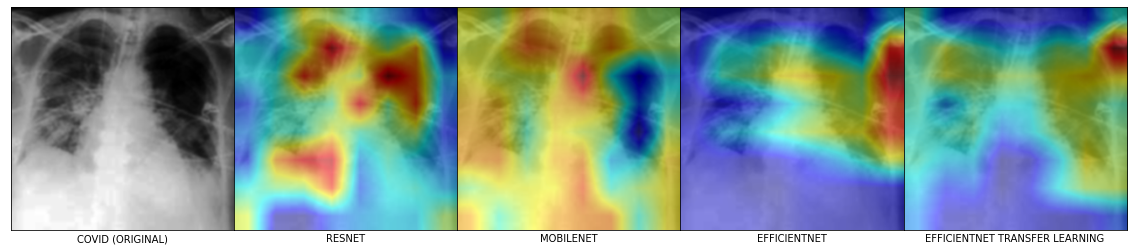

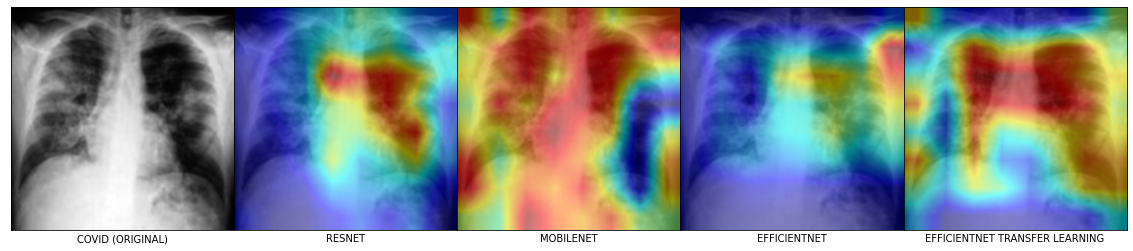

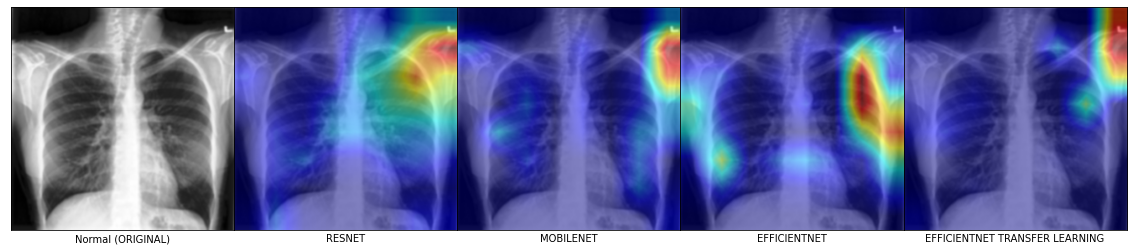

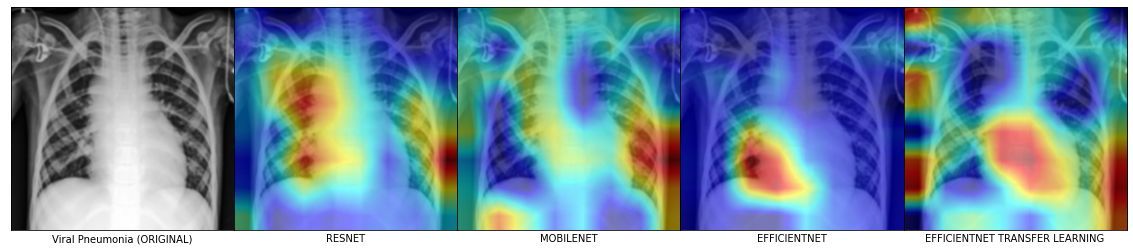

In [206]:
import warnings
warnings.filterwarnings("ignore")

for i in range(len(image)):

  image1 = image[i].to(device)
  label1 = label[i].to(device)

  #sample_fname, _ = data_loaders['test'].dataset.samples[i]
  image1 = image1.view(1,3,256, 256)

  cam_obj = GradCAM(model=model_pyt, target_layer=model_pyt.layer4[-1])
  _, res_cam = cam_obj(image1, label1)

  cam_obj = GradCAM(model=model_pyt2, target_layer=model_pyt2.features[-1]) 
  _, mobile_cam = cam_obj(image1, label1)

  cam_obj = GradCAM(model=model_pyt3, target_layer=model_pyt3.features[-1]) 
  _, efficient_cam = cam_obj(image1, label1)

  cam_obj = GradCAM(model=model_pyt4, target_layer=model_pyt4.features[-1]) 
  _, efficient_cam_tl = cam_obj(image1, label1)

  image1 = deprocess_image(image1)
  resnet_img = apply_mask(image1, res_cam)[:, :, ::-1]
  mobile_img = apply_mask(image1, mobile_cam)[:, :, ::-1]
  eff_img = apply_mask(image1, efficient_cam)[:, :, ::-1]
  eff_img_tl = apply_mask(image1, efficient_cam_tl)[:, :, ::-1]

  fig, (ax1, ax2, ax3, ax4,ax5) = plt.subplots(1,5, figsize=(20,6))

  plt.setp((ax1,ax2,ax3,ax4,ax5), xticks=[],yticks=[])

  ax1.imshow(image1)
  ax1.set_xlabel(str(class_names[label1.item()])+" (ORIGINAL)")
 # ax1.set_title("Class:"+str(class_names[label1.item()]))
  ax2.imshow(resnet_img)
  ax2.set_xlabel("RESNET")
  ax3.imshow(mobile_img)
  ax3.set_xlabel("MOBILENET")
  ax4.imshow(eff_img)
  ax4.set_xlabel("EFFICIENTNET")
  ax5.imshow(eff_img_tl)
  ax5.set_xlabel("EFFICIENTNET TRANSFER LEARNING")

  plt.subplots_adjust(wspace=0.00, hspace=0.00)
  plt.savefig('gradcam_covid_pneumonia.eps', format='eps')

In [207]:
  plt.savefig('gradcam_covid_pneumonia.eps', format='eps')

<Figure size 432x288 with 0 Axes>